In [1]:
using_colab = True

In [2]:
if using_colab:

    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/36_7-3.las'
    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/Ruben_Interactive2.gif'
    !wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/log_responses.xlsx'

    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    !pip install lasio


# This is an example of optimization method by Ruben Charles found on LinkedIn and a repository in GitHub to estimate the rock's components fractions. 

According to Ruben, "Usually you will find this method as probabilistic, or some sort mineralogical solution name.

This is a very bare bone approach with the only intend of testing capabilites of #python, #scipy, #matplotlib and i invite you to check the notebook and play whith it."

We have found Ruben's meithod used in this notebook to be quite interesting and useful. Ruben's GitHib repository and Notebook can be found at the following link:

https://github.com/ruben-charles/petrophysical_evaluation_optimization_methods/blob/70eae4e8825ae0540351289506ba84be0c20f3a3/petrophysical_evaluation_optimization_methods.ipynb


Ruben has presented a minimalist approach in this method, primarily focusing on testing the capabilities of Python, SciPy, and Matplotlib. We encourage you to explore the accompanying notebook and experiment with it.

We found Ruben's optimization method intriguing and valuable, leading us to make a few enhancements to his code in our fork of his GitHub repository. The changes we made include:

    1 The User can now select the logging tools they want to use for the optimization.
    2 Using the same logic we can also turn off the Bulk Density tool in badhole conditions.
    3 In the process we automatically computing what Ruben refers to as "magical numbers." These numbers normalize the magnitudes of each log curve, ensuring equal weighting in the optimization process.
    4 Utilizing Jupyter Notebook's Python Widgets to create a slider, we can interactively adjustment of the depth plot within a discrete depth range. This feature can be particularly useful for generating depth plots at specific log scales using Matplotlib and allowing for scrolling through the data. 
    5 Incorporating additional tops into the depth plots to demonstrate how tops can be effectively utilized.


![Depth_Plot_Image](Ruben_Interactive2.gif)


## Import libraries:

In [3]:
import lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.optimize import minimize
import ipywidgets as widgets

import panel as pn
pn.extension()



## Import LAS file and generate a Pandas DataFrame over a certain reservoir interval:

In [4]:
lasfile = lasio.read("36_7-3.las")

logs = lasfile.df()

logs.reset_index(inplace=True)

logs = logs.loc[(logs["DEPT"] >= 2500)  & (logs["DEPT"] <= 2700)].reset_index()

#############################################################
# Copy Logs with correct names for plot definitions
#############################################################
logs['ILD'] = logs['RDEP']
logs['ILM'] = logs['RMED']

#############################################################
# Tops
#############################################################
tops        = ('TOP of ZONE','BOTTOM of ZONE', 'TD' )
tops_depths = (     2510    ,     2695       , 2700 )


#############################################################
# Plot Limits
#############################################################
top_depth    = min(logs['DEPT'])
bottom_depth = max(logs['DEPT'])


In [5]:
logs.describe()

,index,DEPT,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,PEF,GR,DTC,RDEP,RMED,ILD,ILM
count,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000
mean,1371.000000,2599.992646,7.038842,7.599500,2.460529,0.272810,2.460529,2.460529,91.430848,96.417856,4.166256,4.129497,4.166256,4.129497
std,379.174762,57.786237,4.178836,0.000003,0.121053,0.038617,0.121053,0.121053,26.448164,8.041995,3.404666,3.401247,3.404666,3.401247
min,715.000000,2500.018311,2.000000,7.599400,2.190156,0.099500,2.190156,2.190156,50.943001,68.603821,0.751170,0.836115,0.751170,0.836115
25%,1043.000000,2550.005371,4.000000,7.599500,2.359016,0.252204,2.359016,2.359016,67.386902,90.654999,2.207200,2.173718,2.207200,2.173718
50%,1371.000000,2599.992676,6.000000,7.599500,2.487900,0.273400,2.487900,2.487900,86.939102,97.842003,3.248400,3.135000,3.248400,3.135000
75%,1699.000000,2649.979980,13.000000,7.599500,2.545200,0.294805,2.545200,2.545200,116.533318,102.133896,5.036400,5.067900,5.036400,5.067900
max,2027.000000,2699.967041,16.000000,7.599500,2.866500,0.390796,2.866500,2.866500,143.535584,119.438560,30.409100,31.963423,30.409100,31.963423


## Import the table containing the components log responses to make a dictionary of log responses:

In [6]:
responses_table = pd.read_excel("log_responses.xlsx", index_col=0)

response_dict = responses_table.to_dict(orient="dict")

responses ={}
for i in response_dict:
    for j in response_dict[i]:
        responses[(j + "_" + i)] = response_dict[i][j]



#print(responses_table.head())
#print()
#responses
pn.pane.DataFrame(responses_table, width=400)

DataFrame(DataFrame, width=400)

# Optimization for Calculating Lithology:

## Initiate curves and set Bounds and Constraints for Optimization:

#### Run the next two cells only once, or you will get an error message because of the bounds and constraints.

In [7]:
VOL_QUARTZ         = 0.2
VOL_CALCITE        = 0.2
VOL_DOLOMITE       = 0.2
VOL_SH             = 0.2
VOL_MUD            = 0.2


logs["GR_RECON"]   = VOL_QUARTZ*responses["GR_QUARTZ"]   + VOL_CALCITE*responses["GR_CALCITE"]   +VOL_DOLOMITE*responses["GR_DOLOMITE"]   +VOL_SH*responses["GR_SH"]   +VOL_MUD*responses["GR_MUD"]
logs["NPHI_RECON"] = VOL_QUARTZ*responses["NPHI_QUARTZ"] + VOL_CALCITE*responses["NPHI_CALCITE"] +VOL_DOLOMITE*responses["NPHI_DOLOMITE"] +VOL_SH*responses["NPHI_SH"] +VOL_MUD*responses["NPHI_MUD"]
logs["RHOB_RECON"] = VOL_QUARTZ*responses["RHOB_QUARTZ"] + VOL_CALCITE*responses["RHOB_CALCITE"] +VOL_DOLOMITE*responses["RHOB_DOLOMITE"] +VOL_SH*responses["RHOB_SH"] +VOL_MUD*responses["RHOB_MUD"]
logs["DTC_RECON"]  = VOL_QUARTZ*responses["DTC_QUARTZ"]  + VOL_CALCITE*responses["DTC_CALCITE"]  +VOL_DOLOMITE*responses["DTC_DOLOMITE"]  +VOL_SH*responses["DTC_SH"]  +VOL_MUD*responses["DTC_MUD"]
logs["PEF_RECON"]  = VOL_QUARTZ*responses["PEF_QUARTZ"]  + VOL_CALCITE*responses["PEF_CALCITE"]  +VOL_DOLOMITE*responses["PEF_DOLOMITE"]  +VOL_SH*responses["PEF_SH"]  +VOL_MUD*responses["PEF_MUD"]
logs['Error']      = 1


In [8]:
#Mineral volumen bounds
bnds = ((0, 1), (0, 1), (0, 0.1), (0, 1), (0, 0.45))


def constraint1(x):
    return x[0]+x[1]+x[2]+x[3]+x[4]-1

cons = [{"type": "eq", "fun": constraint1}]

logs.reset_index(inplace=True)


## What logging tools do you want to use in the Optimization?

In [9]:
optim_group = pn.widgets.CheckBoxGroup(
    name='Shale Indicators', value=['GR', 'NPHI','RHOB','DT'], options = ["GR", "NPHI", "RHOB", "DT", "PEF"] ,
    inline=True)

optim_group

CheckBoxGroup(inline=True, name='Shale Indicators', options=['GR', 'NPHI', ...], value=['GR', 'NPHI', ...])

## Run this cell and all cells below to initialize the user's well curves that will be used in the Optimization process:

In [10]:
possible_array = ['GR', 'NPHI', 'RHOB', 'DT', 'PEF']
final_array = optim_group.value

tools = {}

for i, tool in enumerate(possible_array):
    if tool in final_array:
        globals()[f"tool{i}"] = 1
        tools[f"tool{i}"] = 1
    else:
        globals()[f"tool{i}"] = 0
        tools[f"tool{i}"] = 0

#print(tools)

for key, value in tools.items():
    print(f"{key} = {value}")
    
#print()    
#print('tool0 =',tool0, ', tool1 =', tool1, ', tool2 =', tool2, ', tool3 =', tool3, ', tool4 =', tool4)

tool0 = 1
tool1 = 1
tool2 = 1
tool3 = 1
tool4 = 0


## Calculate Ruben's Magic Numbers used to weight each tool:

- Each Magic number is calculated by the mean of the GR tool (highest magnitude curve) divided by the mean of each tool.

- Each of these Magic numbers are then multiplied by their corresponding tool0 like number. If a tool is not used, then the tool number is a zero and this is how the tool is removed from the optimization. 

In [11]:
mean_GR = np.mean(logs["GR"])
#mean_GR

mean_NPHI = np.mean(logs["NPHI"])
#mean_NPHI

mean_RHOB = np.mean(logs["RHOB"])
#mean_RHOB

mean_PEF = np.mean(logs["PEF"])
#mean_PEF

mean_DTC = np.mean(logs["DTC"])
#mean_DTC

print("Mean GR =",mean_GR, ", Mean NPHI =", mean_NPHI,  ", Mean RHOB =",mean_RHOB,  ", Mean PEF =",mean_PEF,  ", Mean DTC =",mean_DTC)
print()
print("Magic Numbers: NPHI =",mean_GR/mean_NPHI, ", RHOB =",mean_GR/mean_RHOB, ", PEF =",mean_GR/mean_PEF, ", DTC =",mean_GR/mean_DTC)


GR_magic   = (mean_GR/mean_GR)*tool0
NPHI_magic = (mean_GR/mean_NPHI)*tool1
RHOB_magic = (mean_GR/mean_RHOB)*tool2
PEF_magic  = (mean_GR/mean_PEF)*tool3
DTC_magic  = (mean_GR/mean_DTC)*tool4



def error_recon(volumes, *args):

    VOL_QUARTZ, VOL_CALCITE, VOL_DOLOMITE, VOL_SH, VOL_MUD = volumes

    GR, NPHI, RHOB, DTC, PEF = args

    GR_RECON   = VOL_QUARTZ*responses["GR_QUARTZ"]   + VOL_CALCITE*responses["GR_CALCITE"]   +VOL_DOLOMITE*responses["GR_DOLOMITE"]   +VOL_SH*responses["GR_SH"]   +VOL_MUD*responses["GR_MUD"]
    NPHI_RECON = VOL_QUARTZ*responses["NPHI_QUARTZ"] + VOL_CALCITE*responses["NPHI_CALCITE"] +VOL_DOLOMITE*responses["NPHI_DOLOMITE"] +VOL_SH*responses["NPHI_SH"] +VOL_MUD*responses["NPHI_MUD"]
    RHOB_RECON = VOL_QUARTZ*responses["RHOB_QUARTZ"] + VOL_CALCITE*responses["RHOB_CALCITE"] +VOL_DOLOMITE*responses["RHOB_DOLOMITE"] +VOL_SH*responses["RHOB_SH"] +VOL_MUD*responses["RHOB_MUD"]
    DTC_RECON  = VOL_QUARTZ*responses["DTC_QUARTZ"]  + VOL_CALCITE*responses["DTC_CALCITE"]  +VOL_DOLOMITE*responses["DTC_DOLOMITE"]  +VOL_SH*responses["DTC_SH"]  +VOL_MUD*responses["DTC_MUD"]
    PEF_RECON  = VOL_QUARTZ*responses["PEF_QUARTZ"]  + VOL_CALCITE*responses["PEF_CALCITE"]  +VOL_DOLOMITE*responses["PEF_DOLOMITE"]  +VOL_SH*responses["PEF_SH"]  +VOL_MUD*responses["PEF_MUD"]


    #Some magic numbers to adjust the precision of differents magnitude orders (needs improvement)
    #return (GR-GR_RECON)**2 + (NPHI*300- NPHI_RECON*300)**2 + (RHOB*100 - 100*RHOB_RECON)**2 + (DTC - DTC_RECON)**2 + (PEF -PEF_RECON)**2
    #return (GR-GR_RECON)**2  + ((NPHI- NPHI_RECON)*(mean_GR/mean_NPHI))**2 + ((RHOB - RHOB_RECON)*(mean_GR/mean_RHOB))**2 + ((DTC - DTC_RECON)*(mean_GR/mean_DTC))**2 + ((PEF - PEF_RECON)*(mean_GR/mean_PEF))**2
    return ((GR-GR_RECON)*(GR_magic))**2  + ((NPHI- NPHI_RECON)*(NPHI_magic))**2 + ((RHOB - RHOB_RECON)*(RHOB_magic))**2 + ((DTC - DTC_RECON)*(DTC_magic))**2 + ((PEF - PEF_RECON)*(PEF_magic))**2


Mean GR = 91.43084799020487 , Mean NPHI = 0.27281011978225433 , Mean RHOB = 2.460529158520868 , Mean PEF = 2.460529157249657 , Mean DTC = 96.41785553506017

Magic Numbers: NPHI = 335.14463489543994 , RHOB = 37.159018284167765 , PEF = 37.15901830336565 , DTC = 0.9482771368728286


## Optimization code and Calculate Error: 

In [12]:
for i in range(len(logs)):

    res = minimize(error_recon, ((0, 0, 0, 0, 0)), args=(logs.loc[i, "GR"], logs.loc[i, "NPHI"], logs.loc[i, "RHOB"], logs.loc[i, "DTC"], logs.loc[i, "PEF"]), bounds= bnds, constraints=cons)

    VOL_QUARTZ    = res.x[0]
    VOL_CALCITE   = res.x[1]
    VOL_DOLOMITE  = res.x[2]
    VOL_SH        = res.x[3]
    VOL_MUD       = res.x[4]
    
    logs.loc[i, "GR_RECON"]   = VOL_QUARTZ*responses["GR_QUARTZ"]   + VOL_CALCITE*responses["GR_CALCITE"]   +VOL_DOLOMITE*responses["GR_DOLOMITE"]   +VOL_SH*responses["GR_SH"]   +VOL_MUD*responses["GR_MUD"]
    logs.loc[i, "NPHI_RECON"] = VOL_QUARTZ*responses["NPHI_QUARTZ"] + VOL_CALCITE*responses["NPHI_CALCITE"] +VOL_DOLOMITE*responses["NPHI_DOLOMITE"] +VOL_SH*responses["NPHI_SH"] +VOL_MUD*responses["NPHI_MUD"]
    logs.loc[i, "RHOB_RECON"] = VOL_QUARTZ*responses["RHOB_QUARTZ"] + VOL_CALCITE*responses["RHOB_CALCITE"] +VOL_DOLOMITE*responses["RHOB_DOLOMITE"] +VOL_SH*responses["RHOB_SH"] +VOL_MUD*responses["RHOB_MUD"]
    logs.loc[i, "DTC_RECON"]  = VOL_QUARTZ*responses["DTC_QUARTZ"]  + VOL_CALCITE*responses["DTC_CALCITE"]  +VOL_DOLOMITE*responses["DTC_DOLOMITE"]  +VOL_SH*responses["DTC_SH"]  +VOL_MUD*responses["DTC_MUD"]
    logs.loc[i, "PEF_RECON"]  = VOL_QUARTZ*responses["PEF_QUARTZ"]  + VOL_CALCITE*responses["PEF_CALCITE"]  +VOL_DOLOMITE*responses["PEF_DOLOMITE"]  +VOL_SH*responses["PEF_SH"]  +VOL_MUD*responses["PEF_MUD"]

    logs.loc[i, "VOL_QUARTZ"]  = VOL_QUARTZ
    logs.loc[i, "VOL_CALCITE"] = VOL_CALCITE
    logs.loc[i, "VOL_DOLOMITE"]= VOL_DOLOMITE
    logs.loc[i, "VOL_SH"]      = VOL_SH
    logs.loc[i, "VOL_MUD"]     = VOL_MUD
    
    # normalize log curves to generate error
    rhob_norm = (logs.loc[i,"RHOB"] - 1.9)/(3.0 - 1.9)
    rhob_norm_theo = (logs.loc[i, "RHOB_RECON"] - 1.9)/(3.0 - 1.9)
    tnph_norm = ((logs.loc[i,"NPHI"] - (-0.05))/(0.6 - (-0.05)))
    tnph_norm_theo = (logs.loc[i, "NPHI_RECON"] - (-0.05))/(0.6 - (-0.05))    
    gr_norm = ( logs.loc[i, "GR"] -  0)/(200 - 0)
    gr_norm_theo = (logs.loc[i, "GR_RECON"] - 0)/(200 - 0)    
    pef_norm = ( logs.loc[i, "PEF"] -  1)/(6 - 1)
    pef_norm_theo = (logs.loc[i, "PEF_RECON"] - 1)/(6 - 1)    
    dtc_norm = ( logs.loc[i, "DTC"] -  40)/(140 - 40)
    dtc_norm_theo = (logs.loc[i, "DTC_RECON"] - 40)/(140 - 40)    


    #logs.loc[i, "Error"] = (0.333*abs((rhob_norm-rhob_norm_theo)+(tnph_norm-tnph_norm_theo)+(gr_norm-gr_norm_theo)+(pef_norm-pef_nor+(dtc_norm-dtc_norm_theo)))
    logs.loc[i, "Error"] = (abs((( gr_norm-gr_norm_theo)*tool0
                                +  (tnph_norm-tnph_norm_theo)*tool1
                                +  (rhob_norm-rhob_norm_theo)*tool2
                                +  (dtc_norm-dtc_norm_theo)*tool3
                                +  (pef_norm-pef_norm_theo)*tool4 )))

    
print(logs['Error'].describe())    



/Users/craig/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


count    1313.000000
mean        0.063236
std         0.054372
min         0.000050
25%         0.022396
50%         0.049469
75%         0.089738
max         0.452535
Name: Error, dtype: float64


# Depth Plot Definitions:

In [13]:
def Plot_lith():
    
    fig = plt.figure(figsize=(20, 15))

    ax =[]

    ax.append(fig.add_subplot(1, 9, (1, 1)))
    ax.append(fig.add_subplot(1, 9, (2, 2), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (3, 3), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (4, 4), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (5, 5), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (6, 6), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (7, 7), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (8, 8), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (9, 9), sharey=ax[0]))


    ax[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(50))
    ax[0].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))
    ax[0].invert_yaxis()
    ax[0].plot(logs["GR"], logs["DEPT"], color="green")
    ax[0].set_xlabel("GR [°API]", color="green")
    ax[0].tick_params(which="both", top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[0].xaxis.set_label_position("top")
    ax[0].set_xlim(0, 200)
    ax[0].grid(True, which="both")


    t1 = ax[1].twiny()
    t1.plot(logs["RHOB"], logs["DEPT"], color="red")
    t1.set_xlabel("RHOB [g/cc]", color ="red")
    t1.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t1.xaxis.set_label_position("top")
    t1.spines.top.set_position(("axes",1.1))
    t1.set_xlim(1.95, 2.95)


    #t2 = ax[1].twiny()
    #t2.plot(logs["DTC"], logs["DEPT"], color="green")
    #t2.set_xlabel("DTC [us/ft]")
    #t2.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    #t2.xaxis.set_label_position("top")

    #t2.spines.top.set_position(("axes",1.06))
    #t2.set_xlim(140, 40)

    ax[1].plot(logs["NPHI"], logs["DEPT"], color="blue")
    ax[1].set_xlabel("NPHI [v/v]", color="blue")
    ax[1].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[1].xaxis.set_label_position("top")
    ax[1].set_xlim(0.45, -0.05)
    ax[1].grid(True, which="both")

    #ax[2].semilogx(logs["ILD"], logs["DEPT"], color="black")
    ax[2].plot(logs["ILD"], logs["DEPT"], "--", color="black")
    ax[2].set_xscale('log')    
    ax[2].set_xlabel("ILD [ohm*m]")
    ax[2].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[2].xaxis.set_label_position("top")
    ax[2].set_xlim(.2, 200)
    ax[2].grid(True, which="both")


    ax[3].plot(logs["GR"], logs["DEPT"], "--", color="black")
    ax[3].plot(logs["GR_RECON"], logs["DEPT"], "-", color="red")
    ax[3].set_xlim(0, 200)
    ax[3].set_xlabel("GR [°API]\n recon", color ="red")
    ax[3].xaxis.set_label_position("top")
    ax[3].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[3].grid(True, which="both")

    
    ax[4].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[4].set_xlabel("NPHI [v/v]\n recon", color ="red")
    ax[4].xaxis.set_label_position("top")
    ax[4].plot(logs["NPHI"], logs["DEPT"], "--", color="black")
    ax[4].plot(logs["NPHI_RECON"], logs["DEPT"], "-", color="red")
    ax[4].set_xlim(0.45, -0.05)
    ax[4].grid(True, which="both")


    ax[5].set_xlabel("RHOB [g/cc]\n recon", color ="red")
    ax[5].xaxis.set_label_position("top")
    ax[5].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[5].plot(logs["RHOB"], logs["DEPT"], "--", color="black")
    ax[5].plot(logs["RHOB_RECON"], logs["DEPT"], "-", color="red")
    ax[5].set_xlim(1.95, 2.95)
    ax[5].grid(True, which="both")


    ax[6].set_xlabel("DTC [us/ft]\n recon", color ="red")
    ax[6].xaxis.set_label_position("top")
    ax[6].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[6].plot(logs["DTC"], logs["DEPT"], "--", color="black")
    ax[6].plot(logs["DTC_RECON"], logs["DEPT"], "-", color="red")
    ax[6].set_xlim(140, 40)
    ax[6].grid(True, which="both")

    #ax[7].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    #ax[7].plot(logs["PEF"], logs["DEPT"], "--", color="black")
    #ax[7].plot(logs["PEF_RECON"], logs["DEPT"], "-", color="red")
    #ax[7].set_xlim(0, 5)


    ax[7].set_xlabel("VOL_SH [v/v]", color = 'red')
    ax[7].xaxis.set_label_position("top")
    ax[7].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[7].plot(logs["VOL_SH"]                                                             , logs["DEPT"], color="black",  linewidth=0)
    ax[7].plot(logs["VOL_SH"]+logs['VOL_QUARTZ']                                          , logs["DEPT"], color="black", linewidth=0)
    ax[7].plot(logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']                      , logs["DEPT"], color="black", linewidth=0)
    ax[7].plot(logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']+logs['VOL_DOLOMITE'] , logs["DEPT"], color="black", linewidth=0)
    ax[7].set_xlim(0, 1)
    ax[7].fill_betweenx(logs["DEPT"], 0.0                                                  , logs["VOL_SH"]                                                            , facecolor='#d1d1d1' , hatch='-.-.',label= 'VOL_SH')
    ax[7].fill_betweenx(logs["DEPT"], logs["VOL_SH"]                                       , logs["VOL_SH"]+logs['VOL_QUARTZ']                                         , facecolor='#ffff00' ,hatch='..',label='VOL_QUARTZ')
    ax[7].fill_betweenx(logs["DEPT"], logs["VOL_SH"]+logs['VOL_QUARTZ']                    , logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']                     , facecolor='#00ffff' ,hatch='|-|-',label='VOL_CALCITE')
    ax[7].fill_betweenx(logs['DEPT'], logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE'], logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']+logs['VOL_DOLOMITE'], facecolor='#00ff00' ,hatch='/-/-',label='VOL_DOLOMITE')
    ax[7].fill_betweenx(logs['DEPT'], logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']+logs['VOL_DOLOMITE'] ,1, color="black")
    ax[7].legend(loc='upper left')


    #ax[7].fill_betweenx(logs["DEPT"], 0.5, logs["VOL_SH"], where=logs["VO L_SH"]>0.5, color="gray", alpha=0.5)

    ax[8].set_xlabel("PHIT [v/v]", color = 'red')
    ax[8].xaxis.set_label_position("top")
    ax[8].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[8].plot(logs["VOL_MUD"], logs["DEPT"], "-", color="black")
    ax[8].set_xlim(0.5, 0.)
    #ax[8].fill_betweenx(logs["DEPT"], 0.12, logs["VOL_MUD"], where=logs["VOL_MUD"]>0.12, color="green", alpha=1, label = "PHIT")
    ax[8].fill_betweenx(logs["DEPT"], 0.0, logs["VOL_MUD"], color="cyan", alpha=1, label = "PHIT")
    ax[8].fill_betweenx(logs["DEPT"], 0.12, logs["VOL_MUD"], where=logs["VOL_MUD"]>0.12, color="olive", alpha=1, label = "Net Res")  
    #ax[8].plot(logs["Error"], logs["DEPT"], color="red")
    #ax[8].fill_betweenx(logs["DEPT"], 0.0, logs["Error"], color="red", alpha=1.0, label = "Error")
    ax[8].legend(loc='upper left')
    ax[8].grid(True, which="both")

    #fig.tight_layout()
    fig.savefig("fig1.png", bbox_inches="tight")


    plt.show()
    #return fig

In [14]:
def Plot_lith2(depth_range):
    top_summary = int_range_slider.value[0]
    bottom_summary = int_range_slider.value[1]
   
    fig = plt.figure(figsize=(20, 15))

    ax =[]

    ax.append(fig.add_subplot(1, 9, (1, 1)))
    ax.append(fig.add_subplot(1, 9, (2, 2), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (3, 3), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (4, 4), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (5, 5), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (6, 6), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (7, 7), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (8, 8), sharey=ax[0]))
    ax.append(fig.add_subplot(1, 9, (9, 9), sharey=ax[0]))

    #General setting for all axis concentrating only on the Zone of Interest
    for axes in ax:
        axes.set_ylim (top_summary,bottom_summary)
        #axes.set_ylim (top_depth,bottom_depth)
        #axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False)
        for i in tops_depths:
                if ((i>=top_summary) and (i<=bottom_summary)):
                    axes.axhline(y=i, linewidth=1.0, color='red')
    for (i,j) in zip(tops_depths,tops):
        if ((i>=top_summary) and (i<=bottom_summary)):
            ax[0].text(0.2, i ,j, horizontalalignment='right',verticalalignment='center', color='red')                
    
    t0 = ax[0].twiny()
    t0.set_xlabel("GR [API]", color ="green")
    t0.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t0.xaxis.set_label_position("top")
    t0.spines.top.set_position(("axes",1.1))
    t0.set_xlim(0, 200)

    ######ax[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))
    #########ax[0].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
    ax[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(50))
    ax[0].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))
    ax[0].invert_yaxis()
    ax[0].plot(logs["GR"], logs["DEPT"], color="green")
    ax[0].set_xlabel("GR [°API]", color="green")
    ax[0].tick_params(which="both", top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[0].xaxis.set_label_position("top")
    ax[0].set_xlim(0, 200)
    ax[0].grid(True, which="both")

    

    t1 = ax[1].twiny()
    t1.plot(logs["RHOB"], logs["DEPT"], color="red")
    t1.set_xlabel("RHOB [g/cc]", color ="red")
    t1.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t1.xaxis.set_label_position("top")
    t1.spines.top.set_position(("axes",1.1))
    t1.set_xlim(1.95, 2.95)

    ax[1].plot(logs["NPHI"], logs["DEPT"], color="blue")
    ax[1].set_xlabel("NPHI [v/v]", color="blue")
    ax[1].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[1].xaxis.set_label_position("top")
    ax[1].set_xlim(0.45, -0.05)
    ax[1].grid(True, which="both")


    
    t2 = ax[2].twiny()
    t2.set_xlabel("ILD [ohmm]", color ="black")
    t2.set_xscale('log')    
    t2.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t2.xaxis.set_label_position("top")
    t2.spines.top.set_position(("axes",1.1))
    t2.set_xlim(0.2, 200)
    
    #ax[2].semilogx(logs["ILD"], logs["DEPT"], color="black")
    ax[2].plot(logs["ILD"], logs["DEPT"], "--", color="black")
    ax[2].set_xscale('log')    
    ax[2].set_xlabel("ILD [ohm*m]")
    ax[2].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[2].xaxis.set_label_position("top")
    ax[2].set_xlim(.2, 200)
    ax[2].grid(True, which="both")

    
    
    t3 = ax[3].twiny()
    t3.set_xlabel("GR [°API]\n recon", color ="red")
    t3.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t3.xaxis.set_label_position("top")
    t3.spines.top.set_position(("axes",1.1))
    t3.set_xlim(0.0, 200)
    
    ax[3].plot(logs["GR"], logs["DEPT"], "--", color="black")
    ax[3].plot(logs["GR_RECON"], logs["DEPT"], "-", color="red")
    ax[3].set_xlim(0, 200)
    ax[3].set_xlabel("GR [°API]\n recon", color ="red")
    ax[3].xaxis.set_label_position("top")
    ax[3].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[3].grid(True, which="both")


    
    
    t4 = ax[4].twiny()
    t4.set_xlabel("NPHI [v/v]\n recon", color ="red")
    t4.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t4.xaxis.set_label_position("top")
    t4.spines.top.set_position(("axes",1.1))
    t4.set_xlim(0.45, -0.15)
    
    ax[4].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[4].set_xlabel("NPHI [v/v]\n recon", color ="red")
    ax[4].xaxis.set_label_position("top")
    ax[4].plot(logs["NPHI"], logs["DEPT"], "--", color="black")
    ax[4].plot(logs["NPHI_RECON"], logs["DEPT"], "-", color="red")
    ax[4].set_xlim(0.45, -0.05)
    ax[4].grid(True, which="both")

    
    
    
    
    t5 = ax[5].twiny()
    t5.set_xlabel("RHOB [g/cc]\n recon", color ="red")
    t5.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t5.xaxis.set_label_position("top")
    t5.spines.top.set_position(("axes",1.1))
    t5.set_xlim(1.95, 2.955)

    ax[5].set_xlabel("RHOB [g/cc]\n recon", color ="red")
    ax[5].xaxis.set_label_position("top")
    ax[5].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[5].plot(logs["RHOB"], logs["DEPT"], "--", color="black")
    ax[5].plot(logs["RHOB_RECON"], logs["DEPT"], "-", color="red")
    ax[5].set_xlim(1.95, 2.95)
    ax[5].grid(True, which="both")


    
    t6 = ax[6].twiny()
    t6.set_xlabel("DTC [us/ft]\n recon", color ="red")
    t6.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t6.xaxis.set_label_position("top")
    t6.spines.top.set_position(("axes",1.1))
    t6.set_xlim(140, 40)
    
    ax[6].set_xlabel("DTC [us/ft]\n recon", color ="red")
    ax[6].xaxis.set_label_position("top")
    ax[6].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[6].plot(logs["DTC"], logs["DEPT"], "--", color="black")
    ax[6].plot(logs["DTC_RECON"], logs["DEPT"], "-", color="red")
    ax[6].set_xlim(140, 40)
    ax[6].grid(True, which="both")

    #ax[7].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    #ax[7].plot(logs["PEF"], logs["DEPT"], "--", color="black")
    #ax[7].plot(logs["PEF_RECON"], logs["DEPT"], "-", color="red")
    #ax[7].set_xlim(0, 5)

    
    
    t7 = ax[7].twiny()
    t7.set_xlabel("Lithology\n Optimized", color ="red")
    t7.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t7.xaxis.set_label_position("top")
    t7.spines.top.set_position(("axes",1.1))
    t7.set_xlim(0, 1)
    

    ax[7].set_xlabel("VOL_SH [v/v]")
    ax[7].xaxis.set_label_position("top")
    ax[7].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[7].plot(logs["VOL_SH"]                                                             , logs["DEPT"], color="black",  linewidth=0)
    ax[7].plot(logs["VOL_SH"]+logs['VOL_QUARTZ']                                          , logs["DEPT"], color="black", linewidth=0)
    ax[7].plot(logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']                      , logs["DEPT"], color="black", linewidth=0)
    ax[7].plot(logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']+logs['VOL_DOLOMITE'] , logs["DEPT"], color="black", linewidth=0)
    ax[7].set_xlim(0, 1)
    ax[7].fill_betweenx(logs["DEPT"], 0.0                                                  , logs["VOL_SH"]                                                            , facecolor='#d1d1d1' , hatch='-.-.',label= 'VOL_SH')
    ax[7].fill_betweenx(logs["DEPT"], logs["VOL_SH"]                                       , logs["VOL_SH"]+logs['VOL_QUARTZ']                                         , facecolor='#ffff00' ,hatch='..',label='VOL_QUARTZ')
    ax[7].fill_betweenx(logs["DEPT"], logs["VOL_SH"]+logs['VOL_QUARTZ']                    , logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']                     , facecolor='#00ffff' ,hatch='|-|-',label='VOL_CALCITE')
    ax[7].fill_betweenx(logs['DEPT'], logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE'], logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']+logs['VOL_DOLOMITE'], facecolor='#00ff00' ,hatch='/-/-',label='VOL_DOLOMITE')
    ax[7].fill_betweenx(logs['DEPT'], logs["VOL_SH"]+logs['VOL_QUARTZ']+logs['VOL_CALCITE']+logs['VOL_DOLOMITE'] ,1, color="black")
    ax[7].legend(loc='lower left')


    #ax[7].fill_betweenx(logs["DEPT"], 0.5, logs["VOL_SH"], where=logs["VO L_SH"]>0.5, color="gray", alpha=0.5)
    '''
    ax[8].set_xlabel("PHIT [v/v]")
    ax[8].xaxis.set_label_position("top")
    ax[8].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[8].plot(logs["VOL_MUD"], logs["DEPT"], "-", color="black")
    ax[8].set_xlim(0.5, 0.)
    #ax[8].fill_betweenx(logs["DEPT"], 0.12, logs["VOL_MUD"], where=logs["VOL_MUD"]>0.12, color="green", alpha=1, label = "PHIT")
    ax[8].fill_betweenx(logs["DEPT"], 0.0, logs["VOL_MUD"], color="cyan", alpha=1, label = "PHIT")
    ax[8].fill_betweenx(logs["DEPT"], 0.12, logs["VOL_MUD"], where=logs["VOL_MUD"]>0.12, color="olive", alpha=1, label = "Net Res")  
    #ax[8].plot(logs["Error"], logs["DEPT"], color="red")
    #ax[8].fill_betweenx(logs["DEPT"], 0.0, logs["Error"], color="red", alpha=1.0, label = "Error")
    ax[8].legend(loc='upper left')
    ax[8].grid(True, which="both")
    '''

    t8 = ax[8].twiny()
    t8.set_xlabel("PHIT", color ="red")
    t8.tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    t8.xaxis.set_label_position("top")
    t8.spines.top.set_position(("axes",1.1))
    t8.set_xlim(0.5, 0)
    
    """
    #5th track: PHIE, BVW
    """
    ax[8].set_xlabel("PHIT [v/v]")
    #ax[8].xaxis.set_label_position("top")
    ax[8].tick_params(labelleft=False, top=True, labeltop=True, bottom=False, labelbottom=False)
    ax[8].plot(logs["VOL_MUD"], logs["DEPT"], "-", color="black")
    ax[8].set_xlim(0.5, 0.)
    #ax[8].fill_betweenx(logs["DEPT"], 0.12, logs["VOL_MUD"], where=logs["VOL_MUD"]>0.12, color="green", alpha=1, label = "PHIT")
    ax[8].fill_betweenx(logs["DEPT"], 0.0, logs["VOL_MUD"], color="cyan", alpha=1, label = "PHIT")
    ax[8].fill_betweenx(logs["DEPT"], 0.12, logs["VOL_MUD"], where=logs["VOL_MUD"]>0.12, color="olive", alpha=1, label = "Net Res")  
    #ax[8].plot(logs["Error"], logs["DEPT"], color="red")
    #ax[8].fill_betweenx(logs["DEPT"], 0.0, logs["Error"], color="red", alpha=1.0, label = "Error")
    ax[8].legend(loc='upper left')
    ax[8].grid(True, which="both")
    
    
    #fig.tight_layout()
    fig.savefig("fig1.png", bbox_inches="tight")

    
    plt.show()
    #return fig

# Optimization Depth Plot:

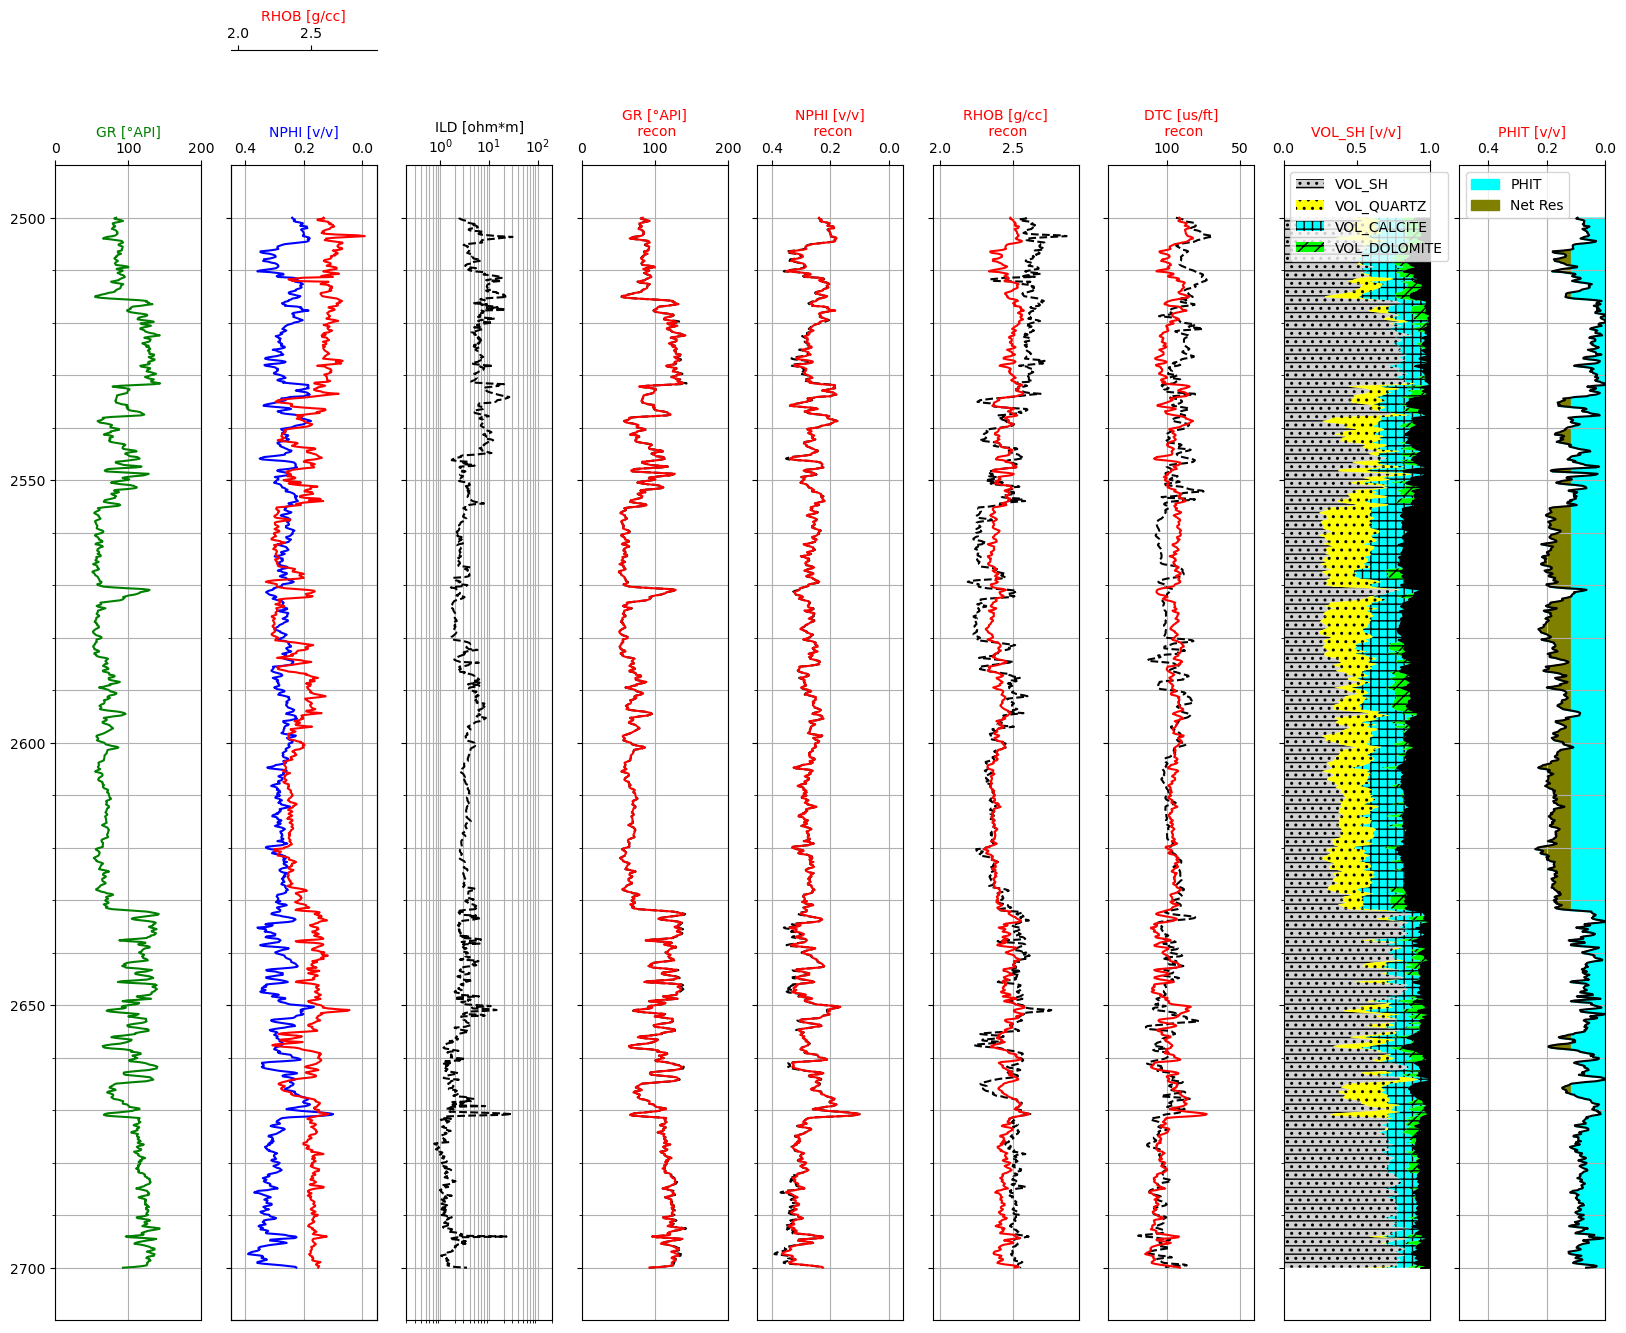

In [15]:
Plot_lith()

# Optimization Depth Plot by Depth Range:

- We can now scroll over a specific interval depth range at a certain scale using this method.
- This could be a new mothod of scrolling for python depth plots. 

In [16]:
int_range_slider = widgets.FloatRangeSlider(
    value  = [2500, 2600] ,
    min    = min(logs.DEPT),
    max    = max(logs.DEPT),
    step   = 1,
    description='Depths:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    #readout=True,
    #readout_format='f',
    slider_color='red',
    color='black'
)


widgets.interactive(Plot_lith2,depth_range  = int_range_slider)

interactive(children=(FloatRangeSlider(value=(2500.0183105, 2600.0), continuous_update=False, description='Dep…